In [36]:
import pandas as pd
import numpy as np

def prepare_test_data(mus, sigmas, n=100):

    # Set the random seed for reproducibility
    np.random.seed(123)

    # Generate random values for three clusters
    cluster1 = np.random.normal(loc=mus[0], scale=sigmas[0], size=n)
    cluster2 = np.random.normal(loc=mus[1], scale=sigmas[1], size=n)
    cluster3 = np.random.normal(loc=mus[2], scale=sigmas[2], size=n)

    # Combine the clusters into a single array
    data = np.concatenate([cluster1, cluster2, cluster3])

    # Create the DataFrame
    df = pd.DataFrame(data, columns=['Value'])
    return df

df = prepare_test_data(mus=[10, 20, 5], sigmas=[3, 3, 3])

,Value
0,6.743108
1,12.992036
2,10.848935
3,5.481116
4,8.264199
...,...
295,7.087362
296,10.627402
297,6.247084
298,5.481633


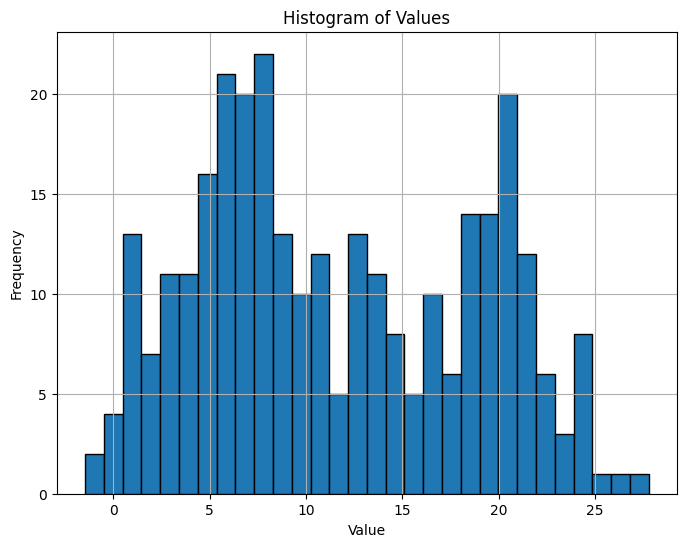

Only 2 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [weights, sigmas, mus]
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNI

Sampling 4 chains for 10 tune and 2 draw iterations (40 + 8 draws total) took 26 seconds.


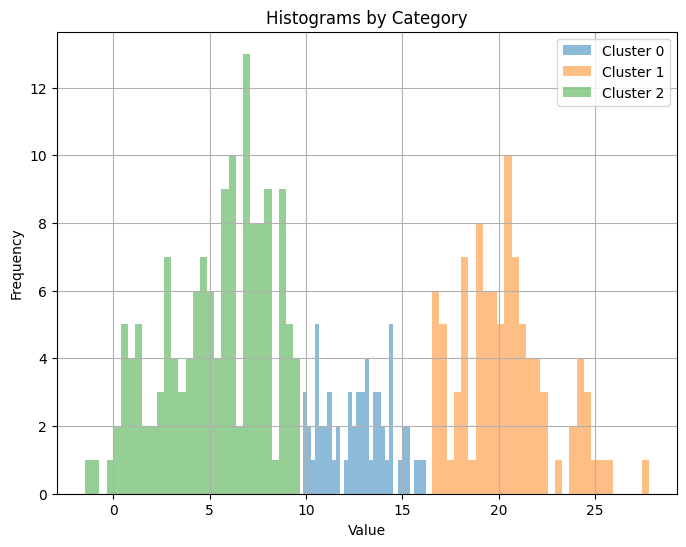

,Value,cluster
0,6.743108,2
1,12.992036,0
2,10.848935,0
3,5.481116,2
4,8.264199,2
...,...,...
295,7.087362,2
296,10.627402,0
297,6.247084,2
298,5.481633,2


In [57]:
def assign_volatility_cluster(df, mus=[10,10,10], sigmas=[3,3,3]):
    """
    Assigns a volatility cluster to each value in the DataFrame.
    Give a df with a column named 'Value', this should be the volatility measure of a given window. 
    Let the index be the window or any arbitrary index.
    """
    import warnings
    warnings.filterwarnings('ignore')
    import pymc3 as pm
    import numpy as np
    import matplotlib.pyplot as plt
    # Plot the histogram of values
    plt.figure(figsize=(8, 6))
    plt.hist(df['Value'], bins=30, edgecolor='black')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title('Histogram of Values')
    plt.grid(True)
    plt.show()
    # Prepare the data
    values = df['Value'].values

    # Define the model
    with pm.Model() as model:
        # Specify the number of clusters
        k = 3
        # Priors for the cluster parameters
        mus = pm.Normal('mus', mu=mus, sd=sigmas, shape=k)
        sigmas = pm.HalfNormal('sigmas', sd=sigmas, shape=k)
        weights = pm.Dirichlet('weights', a=np.ones(k))

        # Likelihood
        likelihood = pm.NormalMixture('likelihood', w=weights, mu=mus, sd=sigmas, observed=values)

        # Sample from the posterior
        trace = pm.sample(2, tune=10)
        
    cluster_means = np.array(trace['mus'][-1])
    diff = cluster_means - df['Value'].values[:, np.newaxis]
    cluster = np.argmin(np.abs(diff), axis=1)
    df['cluster'] = cluster


    # Separate values based on the category column
    category3_values = df[df['cluster'] == 0]['Value']
    category1_values = df[df['cluster'] == 1]['Value']
    category2_values = df[df['cluster'] == 2]['Value']

    # Plot the histograms
    plt.figure(figsize=(8, 6))
    plt.hist(category3_values, bins=30, alpha=0.5, label='Cluster 0')
    plt.hist(category1_values, bins=30, alpha=0.5, label='Cluster 1')
    plt.hist(category2_values, bins=30, alpha=0.5, label='Cluster 2')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title('Histograms by Category')
    plt.legend()
    plt.grid(True)
    plt.show()

    return df

    # Extract the cluster assignments

assign_volatility_cluster(df)